# Global Path Weighting
---
This notebook will implement and evaluate a method to weight hetnet paths in such a way that they can be compared between metapaths. This is an improvement on ranking by path degree product (pdp), as pdps are not comparable for paths that are part of different metapaths.

## Proposed Weighting Method
---
Thanks to the work done on [generating empirical p-values for metapaths](https://github.com/greenelab/hetmech/issues/134), we can compare the relative importance of different metapaths for a given node pair in a hetnet. To allow comparison between individual paths, we can take the negative log of the p-value (for readability), multiply it for the path degree product for the node pair, and adjust the result based on the number of metapaths of that length.

In [1]:
import configparser
import math

import psycopg2
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas

from neo4j.v1 import GraphDatabase
import hetio.readwrite
import hetio.neo4j


/home/benheil/miniconda3/envs/hetmech/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: The 'neo4j.v1' package is deprecated, import from 'neo4j' instead


In [2]:
# The extra quotation marks get SQL to treat the identifiers as strings
compound = "'DB01156'"  # Bupropion
disease = "'DOID:0050742'"  # nicotine dependences

In [3]:
# I created a database.ini file to store the database password
parser = configparser.ConfigParser()
parser.read('database.ini')

db_password = parser['psql']['password']

In [4]:
# Query db with psycopg2 to get the top ten metapaths for this pair, and their p-values

connection = psycopg2.connect(host = 'phr-greene-007.med.upenn.edu', database = 'dj_hetmech', 
                              user = 'read_only_user', password = db_password)

# Get the p-values for the top ten paths for the given compound and disease
query = f"""SELECT n1.name, n2.name, metapath_id, pc.p_value 
            FROM dj_hetmech_app_pathcount pc 
                JOIN dj_hetmech_app_node n1 ON n1.id = source_id 
                JOIN dj_hetmech_app_node n2 ON n2.id = target_id  
            WHERE (n1.identifier={disease} AND n2.identifier={compound}) 
                OR (n1.identifier={compound} AND n2.identifier={disease})  
            ORDER BY pc.p_value ASC 
            LIMIT 10;
        """
print(query)

cursor = connection.cursor()

cursor.execute(query)
tuple_metapaths = cursor.fetchall()

connection.close()

SELECT n1.name, n2.name, metapath_id, pc.p_value 
            FROM dj_hetmech_app_pathcount pc 
                JOIN dj_hetmech_app_node n1 ON n1.id = source_id 
                JOIN dj_hetmech_app_node n2 ON n2.id = target_id  
            WHERE (n1.identifier='DOID:0050742' AND n2.identifier='DB01156') 
                OR (n1.identifier='DB01156' AND n2.identifier='DOID:0050742')  
            ORDER BY pc.p_value ASC 
            LIMIT 10;
        


In [5]:
# Take the negative log of the p-values

# Convert metapaths to a list of lists instead of a tuple of tuples to allow item assignment
list_metapaths = [list(metapath) for metapath in tuple_metapaths]
for i, _ in enumerate(tuple_metapaths):
    list_metapaths[i][3] = -1 * math.log10(tuple_metapaths[i][3])
    
print([metapath[2] for metapath in list_metapaths])

['CbGbCtD', 'CbGaD', 'CbGbCpD', 'CpDrD', 'CdGr>GdD', 'CdGdDrD']


In [6]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
metagraph = hetio.readwrite.read_metagraph(url)

In [7]:
compound = "DB01156"  # Bupropion
disease = "DOID:0050742"  # nicotine dependences

damping_exponent = .4

all_metapath_results = []

for metapath in list_metapaths:
    metapath_data = metagraph.metapath_from_abbrev(metapath[2])
    
    query = hetio.neo4j.construct_pdp_query(metapath_data, path_style='list', property='identifier')
    
    driver = GraphDatabase.driver("bolt://neo4j.het.io")
    params = {
        'source': compound,
        'target': disease,
        'w': damping_exponent
    }
    with driver.session() as session:
        metapath_result = session.run(query, params)
        metapath_result = metapath_result.data()
        all_metapath_results.append(metapath_result)

In [8]:
paths = []

for metapath_result, metapath_info in zip(all_metapath_results, list_metapaths):
    metapath_importance = metapath_info[3]
    for path_dict in metapath_result:
        path_dict['path_importance'] = metapath_importance * path_dict['percent_of_DWPC']
        path_dict['metapath_importance'] = metapath_importance
        path_dict['path'] = '–'.join(path_dict['path'])
        path_dict['metapath_abbr'] = metapath_info[2] 
        paths.append(path_dict)
    
paths = sorted(paths, key= lambda x: x['path_importance'], reverse=True)

pandas.DataFrame(paths).set_index('path')

PDP metapath_abbr  \
path                                                                         
Bupropion–CHRNA3–Varenicline–nicotine dependence    0.028646       CbGbCtD   
Bupropion–CHRNA3–nicotine dependence                0.026062         CbGaD   
Bupropion–attention deficit hyperactivity disor...  0.078028         CpDrD   
Bupropion–CHRNA3–Nicotine–nicotine dependence       0.014665       CbGbCpD   
Bupropion–MRPL19–alcohol dependence–nicotine de...  0.002399       CdGdDrD   
Bupropion–CYP2A6–Nicotine–nicotine dependence       0.003127       CbGbCpD   
Bupropion–CYP2E1–Nicotine–nicotine dependence       0.002064       CbGbCpD   
Bupropion–CYP2B6–Nicotine–nicotine dependence       0.002036       CbGbCpD   
Bupropion–CYP2C8–Nicotine–nicotine dependence       0.001542       CbGbCpD   
Bupropion–CYP1A2–Nicotine–nicotine dependence       0.001194       CbGbCpD   
Bupropion–CYP2C9–Nicotine–nicotine dependence       0.001076       CbGbCpD   
Bupropion–HDAC6–FRAT2–nicotine dependence           0.000763      CdGr>GdD   
Bupropion–CYP2D6–Nicotine–nicotine dependence       0.000983       CbGbCpD   
Bupropion–HDAC6–CCDC88C–nicotine dependence         0.000556      CdGr>GdD   
Bupropion–HDAC6–HIST1H2AE–nicotine dependence       0.000537      CdGr>GdD   
Bupropion–HDAC6–KIAA0930–nicotine dependence        0.000520      CdGr>GdD   
Bupropion–SDHB–LRRC47–nicotine dependence           0.000502      CdGr>GdD   
Bupropion–CYP3A4–Nicotine–nicotine dependence       0.000625       CbGbCpD   
Bupropion–KIF2C–HILPDA–nicotine dependence          0.000446      CdGr>GdD   
Bupropion–HDAC6–DNMBP–nicotine dependence           0.000430      CdGr>GdD   
Bupropion–HDAC6–NCOA1–nicotine dependence           0.000422      CdGr>GdD   
Bupropion–HDAC6–AKAP7–nicotine dependence           0.000394      CdGr>GdD   
Bupropion–STXBP1–PAK1–nicotine dependence           0.000383      CdGr>GdD   
Bupropion–OXA1L–EGLN1–nicotine dependence           0.000379      CdGr>GdD   
Bupropion–SLC25A4–LAMB3–nicotine dependence         0.000367      CdGr>GdD   
Bupropion–MTHFD2–CREBL2–nicotine dependence         0.000358      CdGr>GdD   
Bupropion–HDAC6–LMNB1–nicotine dependence           0.000332      CdGr>GdD   
Bupropion–ATP6V1D–HIST1H2AE–nicotine dependence     0.000276      CdGr>GdD   
Bupropion–OXA1L–EIF3F–nicotine dependence           0.000266      CdGr>GdD   
Bupropion–HDAC6–PAK6–nicotine dependence            0.000262      CdGr>GdD   
Bupropion–ADI1–GNB5–nicotine dependence             0.000259      CdGr>GdD   
Bupropion–SLC25A4–CENPM–nicotine dependence         0.000253      CdGr>GdD   
Bupropion–ATP6V0B–FDPS–nicotine dependence          0.000205      CdGr>GdD   
Bupropion–MRPL19–ANKRD46–nicotine dependence        0.000177      CdGr>GdD   
Bupropion–OXA1L–NT5E–nicotine dependence            0.000165      CdGr>GdD   
Bupropion–ATP6V1D–GABPB1–nicotine dependence        0.000163      CdGr>GdD   
Bupropion–OXA1L–PAK6–nicotine dependence            0.000149      CdGr>GdD   
Bupropion–ATP6V0B–ACAT2–nicotine dependence         0.000148      CdGr>GdD   
Bupropion–GNAS–BNIP3L–nicotine dependence           0.000140      CdGr>GdD   
Bupropion–SDHB–ACAT2–nicotine dependence            0.000137      CdGr>GdD   
Bupropion–USP22–DFFB–nicotine dependence            0.000134      CdGr>GdD   
Bupropion–SLC25A4–ANXA4–nicotine dependence         0.000131      CdGr>GdD   
Bupropion–HDAC6–DCTD–nicotine dependence            0.000118      CdGr>GdD   
Bupropion–HDAC6–PARP2–nicotine dependence           0.000115      CdGr>GdD   
Bupropion–GNAS–GMNN–nicotine dependence             0.000115      CdGr>GdD   
Bupropion–USP22–ACAT2–nicotine dependence           0.000112      CdGr>GdD   
Bupropion–KIF2C–CTNNAL1–nicotine dependence         0.000102      CdGr>GdD   
Bupropion–ATP6V1D–CDK1–nicotine dependence          0.000081      CdGr>GdD   
Bupropion–MTHFD2–CDK1–nicotine dependence           0.000074      CdGr>GdD   
Bupropion–KIF2C–PARP2–nicotine dependence           0.000072      CdGr>GdD   
B

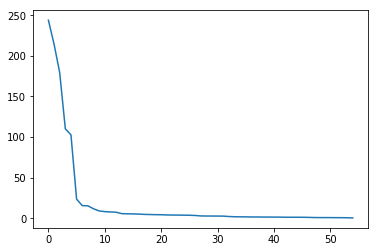

In [9]:
importances = [path['path_importance'] for path in paths]

plt.plot(importances)
plt.show()